In [4]:
# Ajusta la ruta a la ubicación de tu proyecto
import sys
sys.path.append(r"C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\src")

In [5]:
# Celda 1: importaciones y configuración
import os
import pandas as pd
from glob import glob
from mplsoccer import Pitch
import matplotlib.pyplot as plt

# Ajusta esta ruta a tu estructura local
BASE_DIR = r"C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter\Competition\Season"

# Equipo a buscar en nombres de carpetas (minúsculas para comparar)
TEAM_ALIAS = ["real betis", "betis"]  # añade más alias si fuera necesario

# Nombre o ID del jugador que quieres analizar
PLAYER_NAME = "Sergi Altimira"

In [6]:
# Celda 2: construir diccionario de jugadores
from whoscored_viz.dictionaries import build_players_dictionary

# Genera el archivo players_master.csv y carga el dataframe
players_df = build_players_dictionary()

# Filtra por nombre para obtener el ID del jugador
player_row = players_df[players_df['player_name'].str.lower() == PLAYER_NAME.lower()]
if player_row.empty:
    raise ValueError(f"No se ha encontrado el jugador {PLAYER_NAME} en los CSV. Comprueba el nombre.")
player_id = int(player_row.iloc[0]['player_id'])
team_id  = int(player_row.iloc[0]['team_id'])
print(f"Player ID: {player_id}, Team ID: {team_id}")

Player ID: 489232, Team ID: 54


In [7]:
# Celda 3: recolectar recuperaciones del jugador
recoveries = []

for folder_name in os.listdir(BASE_DIR):
    # Filtrar sólo carpetas que contengan el alias del equipo
    if not any(alias in folder_name.lower() for alias in TEAM_ALIAS):
        continue
    
    csv_path = os.path.join(BASE_DIR, folder_name, "csv")
    if not os.path.isdir(csv_path):
        continue
    
    # Buscar el archivo de eventos defensivos; asume que se llama events_defensive.csv
    def_files = [f for f in os.listdir(csv_path) if "events_defensive" in f.lower()]
    if not def_files:
        continue
    
    df = pd.read_csv(os.path.join(csv_path, def_files[0]))
    # Filtrar por ID de jugador y por tipo "BallRecovery"
    df = df[(df['playerId'] == player_id) & (df['typeName'] == 'BallRecovery')]
    
    if not df.empty:
        recoveries.append(df[['x', 'y']])

# Unir todas las recuperaciones en un solo DataFrame
if not recoveries:
    raise ValueError("No se encontraron recuperaciones para el jugador en las carpetas seleccionadas.")
all_recoveries = pd.concat(recoveries, ignore_index=True)
print(f"Total recuperaciones: {len(all_recoveries)}")

Total recuperaciones: 23


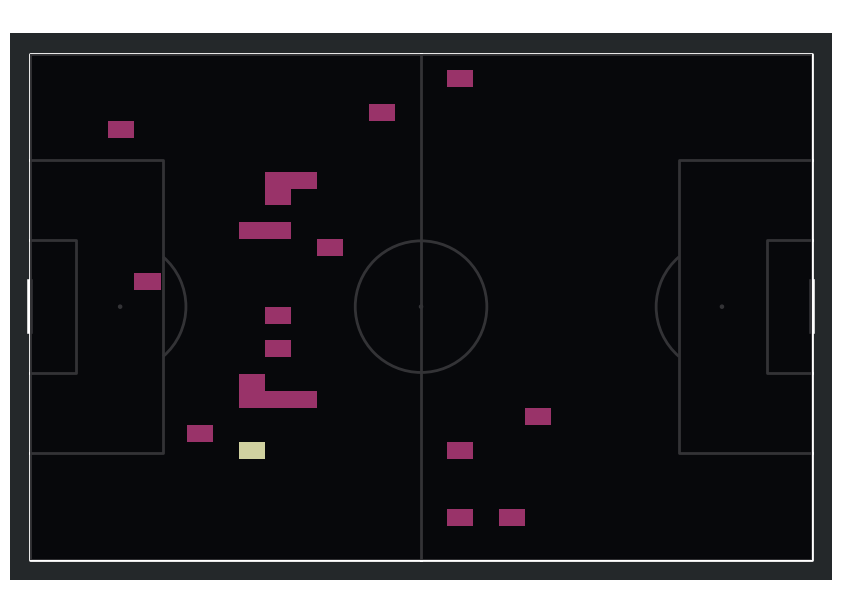

In [8]:
# Celda 4: mapa de calor de recuperaciones
pitch = Pitch(pitch_type='opta',
              pitch_color='#24282a',  # fondo oscuro como tu identidad (#24282a)
              line_color='white',     # líneas blancas
              axis=False, label=False)

fig, ax = pitch.draw(figsize=(10, 6))

# Crear estadística binned de 30x30 celdas; aumenta bins para más detalle
bin_stat = pitch.bin_statistic(
    all_recoveries['x'], all_recoveries['y'],
    bins=(30, 30), statistic='count'
)

# Dibujar heatmap; colormap estándar (puedes probar 'hot', 'magma', 'coolwarm', etc.)
cmap = plt.cm.magma  # o 'hot'
pitch.heatmap(bin_stat, ax=ax, cmap=cmap, edgecolor=None, alpha=0.8)

# Añadir título con nombre de jugador y número de recuperaciones
ax.set_title(f"Mapa de calor de recuperaciones de {PLAYER_NAME} (n={len(all_recoveries)})",
             color='white', fontsize=14)

plt.show()

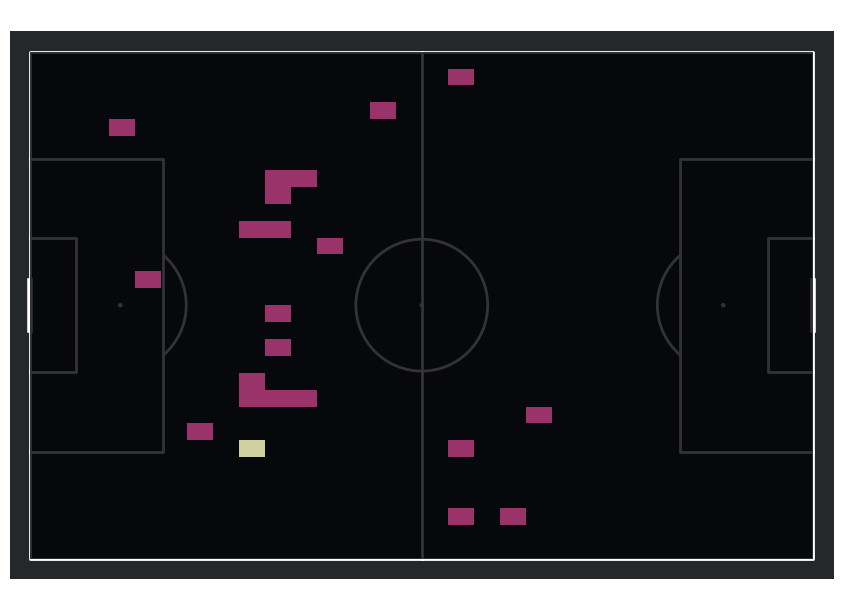

In [10]:
# Celda 5: función automatizada
def plot_recovery_heatmap(base_dir, team_aliases, player_name):
    # Construir diccionario de jugadores y obtener IDs
    players_df = build_players_dictionary()
    row = players_df[players_df['player_name'].str.lower() == player_name.lower()]
    if row.empty:
        raise ValueError(f"Jugador {player_name} no encontrado.")
    player_id = int(row.iloc[0]['player_id'])

    # Recoger recuperaciones
    recs = []
    for folder_name in os.listdir(base_dir):
        if not any(alias in folder_name.lower() for alias in team_aliases):
            continue
        def_path = os.path.join(base_dir, folder_name, "csv", "events_defensive.csv")
        if not os.path.isfile(def_path):
            continue
        df = pd.read_csv(def_path)
        df = df[(df['playerId'] == player_id) & (df['typeName'] == 'BallRecovery')]
        if not df.empty:
            recs.append(df[['x', 'y']])

    if not recs:
        raise ValueError("No se encontraron recuperaciones.")
    coords = pd.concat(recs, ignore_index=True)

    # Plot
    pitch = Pitch(pitch_type='opta', pitch_color='#24282a', line_color='white', axis=False)
    fig, ax = pitch.draw(figsize=(10, 6))
    bin_stat = pitch.bin_statistic(coords['x'], coords['y'], bins=(30, 30), statistic='count')
    pitch.heatmap(bin_stat, ax=ax, cmap=plt.cm.magma, alpha=0.8)
    ax.set_title(f"Mapa de calor de recuperaciones de {player_name} (n={len(coords)})",
                 color='white')
    return fig, ax

# Ejemplo de uso:
fig, ax = plot_recovery_heatmap(BASE_DIR, TEAM_ALIAS, PLAYER_NAME)

In [12]:
# --- Configuración base ---
import os
from pathlib import Path
import pandas as pd
from mplsoccer import Pitch
import matplotlib.pyplot as plt

# Ruta base donde están TODAS las carpetas de partidos
BASE_DIR = Path(r"C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter\Competition\Season")

# Estilo del campo (horizontal), como pediste
PITCH_COLOR = "#e3aca7"
LINE_COLOR  = "#000009"

# Colormap para KDE (usa tu flamingo si quieres)
# from matplotlib.colors import LinearSegmentedColormap
# flamingo_cmap_100 = LinearSegmentedColormap.from_list("flamingo", [...], N=100)
KDE_CMAP   = plt.cm.magma   # cambia por tu flamingo_cmap_100 si lo tienes
KDE_LEVELS = 100

In [13]:
# Haz que Python encuentre tu paquete local: whoscored_viz
import sys
sys.path.append(r"C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\src")

# (Opcional) usar tu diccionario de jugadores/equipos si luego quieres colores o logos
try:
    from whoscored_viz.dictionaries import build_players_dictionary
    from whoscored_viz.identity import team_style  # si quieres colores oficiales por team_id
    HAVE_PROJECT_UTILS = True
except Exception as e:
    print("Aviso: no pude importar tus utilidades del proyecto. Sigo sin ellas.", e)
    HAVE_PROJECT_UTILS = False

In [14]:
def _read_csv_safe(path: Path) -> pd.DataFrame | None:
    try:
        df = pd.read_csv(path)
        if df is not None and len(df):
            return df
    except Exception:
        pass
    return None

def _find_file(csv_dir: Path, name_contains: str) -> Path | None:
    """
    Busca un archivo que contenga name_contains en su nombre dentro de csv_dir.
    """
    if not csv_dir.is_dir():
        return None
    # intento exacto
    f1 = csv_dir / f"{name_contains}.csv"
    if f1.exists():
        return f1
    # intento por contains
    for p in csv_dir.iterdir():
        if p.is_file() and p.suffix.lower()==".csv" and name_contains.lower() in p.name.lower():
            return p
    return None

def _standardize_players(players_df: pd.DataFrame) -> pd.DataFrame:
    """
    Devuelve columnas normalizadas: player_id, player_name, team_id, team_name.
    """
    cols = {c.strip().lower(): c for c in players_df.columns}
    def col(*names):
        for n in names:
            if n in cols: return cols[n]
    pid   = col("player_id","playerid","id")
    pname = col("player_name","name","player")
    tid   = col("team_id","teamid")
    tname = col("team_name","team")
    out = pd.DataFrame({
        "player_id": pd.to_numeric(players_df[pid], errors="coerce") if pid else pd.NA,
        "player_name": players_df[pname].astype(str) if pname else "",
        "team_id": pd.to_numeric(players_df[tid], errors="coerce") if tid else pd.NA,
        "team_name": players_df[tname].astype(str) if tname else "",
    })
    out = out.dropna(subset=["player_id"]).copy()
    out["player_id"] = out["player_id"].astype(int)
    if "team_id" in out.columns:
        out["team_id"] = out["team_id"].astype("Int64")
    return out

def _standardize_def_events(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normaliza lo mínimo: x, y, playerId, teamId, typeName.
    """
    cols = {c.strip().lower(): c for c in df.columns}
    def col(*names):
        for n in names:
            if n in cols: return cols[n]
    x  = col("x")
    y  = col("y")
    pid= col("playerid","player_id")
    tid= col("teamid","team_id")
    tnm= col("teamname","team_name")
    tpe= col("typename","type","event","eventname")
    out = pd.DataFrame({
        "x": pd.to_numeric(df[x], errors="coerce") if x else pd.NA,
        "y": pd.to_numeric(df[y], errors="coerce") if y else pd.NA,
        "playerId": pd.to_numeric(df[pid], errors="coerce").astype("Int64") if pid else pd.NA,
        "teamId": pd.to_numeric(df[tid], errors="coerce").astype("Int64") if tid else pd.NA,
        "teamName": df[tnm].astype(str) if tnm else "",
        "typeName": df[tpe].astype(str) if tpe else "",
    })
    out = out.dropna(subset=["x","y","playerId"])
    return out

In [15]:
def collect_ball_recoveries_all_matches(base_dir: Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Recorre todas las subcarpetas de partidos (sin filtrar por equipo),
    lee events_defensive.csv y players.csv, y devuelve:
      - recoveries_df: x, y, playerId, teamId, teamName
      - ranking_df: playerId, player_name, team_id, team_name, recoveries
    """
    all_recs = []      # coordenadas y metadatos por recuperación
    player_meta = []   # mapeos playerId -> player_name, team_id, team_name

    for match_dir in base_dir.iterdir():
        csv_dir = match_dir / "csv"
        if not csv_dir.is_dir():
            continue

        # players
        pfile = _find_file(csv_dir, "players")
        players_df = _read_csv_safe(pfile) if pfile else None
        if players_df is None:
            continue
        players_std = _standardize_players(players_df)

        # eventos defensivos
        dfile = _find_file(csv_dir, "events_defensive")
        def_df = _read_csv_safe(dfile) if dfile else None
        if def_df is None:
            continue
        def_std = _standardize_def_events(def_df)

        # filtra BallRecovery
        rec = def_std[def_std["typeName"].str.lower().eq("ballrecovery")]
        if rec.empty:
            continue

        # añade nombres/equipos al vuelo
        rec = rec.merge(players_std, left_on="playerId", right_on="player_id", how="left")
        # columnas finales limpias
        rec = rec.rename(columns={"team_name":"teamName_joined"}).copy()
        rec["teamName"] = rec["teamName"].where(rec["teamName"].astype(bool), rec["teamName_joined"])
        rec = rec.drop(columns=["teamName_joined","player_id"])

        all_recs.append(rec[["x","y","playerId","teamId","teamName","player_name","team_id"]])
        player_meta.append(players_std)

    if not all_recs:
        raise RuntimeError("No se encontraron recuperaciones en ninguna carpeta.")

    recoveries_df = pd.concat(all_recs, ignore_index=True)

    # ranking global
    grp = recoveries_df.groupby(["playerId","player_name","teamId","teamName"]).size().reset_index(name="recoveries")
    ranking_df = grp.sort_values("recoveries", ascending=False).reset_index(drop=True)

    return recoveries_df, ranking_df

In [16]:
recoveries_df, ranking_df = collect_ball_recoveries_all_matches(BASE_DIR)

TOP_N = 3
top3 = ranking_df.head(TOP_N).copy()
top3

,playerId,player_name,teamId,teamName,recoveries
0,402197,Pedri,65,Barcelona,34
1,297203,Pablo Fornals,54,Real Betis,30
2,423282,David Affengruber,833,Elche,29


In [17]:
def plot_recovery_kde_for_player(recoveries_df: pd.DataFrame,
                                 player_id: int,
                                 player_name: str,
                                 team_name: str | None = None,
                                 pitch_color: str = PITCH_COLOR,
                                 line_color: str  = LINE_COLOR,
                                 kde_cmap = KDE_CMAP,
                                 kde_levels: int = KDE_LEVELS,
                                 figsize=(5.8, 7.2)):
    """
    Dibuja el KDE de recuperaciones para un jugador usando Pitch.kdeplot (campo horizontal).
    """
    dfp = recoveries_df[recoveries_df["playerId"] == player_id]
    if dfp.empty:
        raise ValueError(f"Sin recuperaciones para playerId={player_id}")

    xs = dfp["x"].values
    ys = dfp["y"].values

    pitch = Pitch(pitch_type="opta", pitch_color=pitch_color, line_color=line_color)
    fig, ax = pitch.draw(figsize=figsize)
    pitch.kdeplot(xs, ys, ax=ax, cmap=kde_cmap, fill=True, levels=kde_levels)

    title_team = f" ({team_name})" if team_name else ""
    ax.set_title(f"{player_name}{title_team} · Recuperaciones (n={len(dfp)})", color=line_color, fontsize=11)
    plt.show()

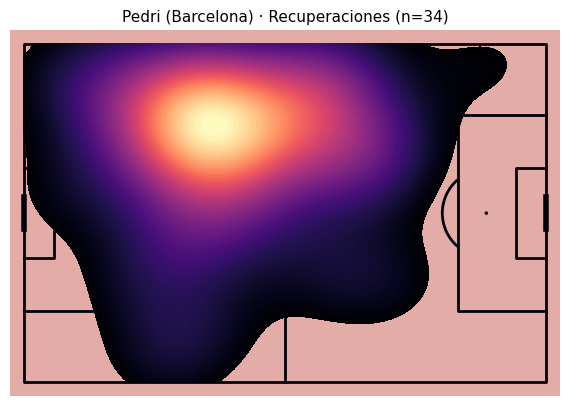

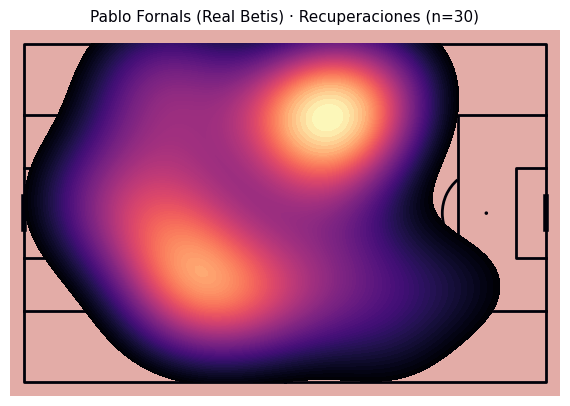

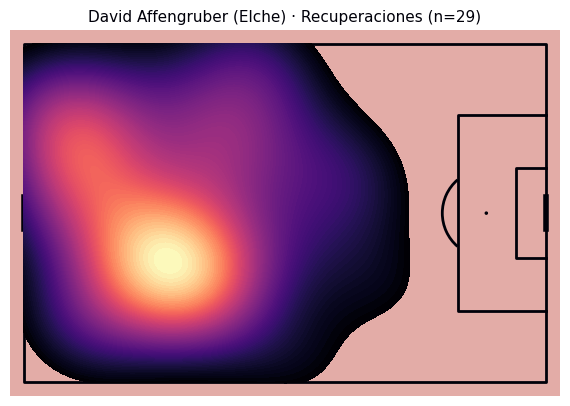

In [18]:
for _, row in top3.iterrows():
    pid  = int(row["playerId"])
    pname= str(row["player_name"])
    tname= str(row["teamName"])
    plot_recovery_kde_for_player(recoveries_df, pid, pname, tname)

In [19]:
# === Config global ===
import os
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Ruta base con TODAS las carpetas de partidos
BASE_DIR = Path(r"C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter\Competition\Season")

# Carpeta donde guardar imágenes (se crea si no existe)
OUTPUT_DIR = BASE_DIR / "_outputs" / "heatmaps_recoveries"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Colores corporativos (ajusta si lo tienes en tu identity.py)
PITCH_COLOR = "#24282a"   # fondo pro
LINE_COLOR  = "#ffffff"   # líneas visibles

# Transparencia y detalle del KDE (más bajo = más translúcido)
KDE_ALPHA   = 0.45
KDE_LEVELS  = 80

# Colormap: usa el tuyo si lo tienes
# Si tienes flamingo_cmap_100 en tu proyecto:
try:
    sys.path.append(r"C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\src")
    from whoscored_viz.identity import flamingo_cmap_100 as KDE_CMAP
except Exception:
    KDE_CMAP = plt.cm.magma  # plan B decente

In [20]:
def _read_csv_safe(path: Path) -> pd.DataFrame | None:
    try:
        df = pd.read_csv(path)
        if df is not None and len(df):
            return df
    except Exception:
        pass
    return None

def _find_file(csv_dir: Path, name_contains: str) -> Path | None:
    """
    Busca en csv_dir un .csv cuyo nombre contenga name_contains (case-insensitive).
    Intenta primero el nombre exacto '<name_contains>.csv'.
    """
    if not csv_dir.is_dir():
        return None
    exact = csv_dir / f"{name_contains}.csv"
    if exact.exists():
        return exact
    for p in csv_dir.iterdir():
        if p.is_file() and p.suffix.lower() == ".csv" and name_contains.lower() in p.name.lower():
            return p
    return None

def _standardize_players(players_df: pd.DataFrame) -> pd.DataFrame:
    """
    Devuelve columnas normalizadas: player_id, player_name, team_id, team_name.
    Hace mapping flexible por si cambian encabezados.
    """
    cols = {c.strip().lower(): c for c in players_df.columns}
    def col(*names):
        for n in names:
            if n in cols: return cols[n]
    pid   = col("player_id","playerid","id")
    pname = col("player_name","name","player")
    tid   = col("team_id","teamid")
    tname = col("team_name","team")

    out = pd.DataFrame({
        "player_id": pd.to_numeric(players_df[pid], errors="coerce") if pid else pd.NA,
        "player_name": players_df[pname].astype(str) if pname else "",
        "team_id": pd.to_numeric(players_df[tid], errors="coerce") if tid else pd.NA,
        "team_name": players_df[tname].astype(str) if tname else "",
    })
    out = out.dropna(subset=["player_id"]).copy()
    out["player_id"] = out["player_id"].astype(int)
    if "team_id" in out.columns:
        out["team_id"] = out["team_id"].astype("Int64")
    return out

def _standardize_def_events(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normaliza lo mínimo: x, y, playerId, teamId, teamName, typeName.
    """
    cols = {c.strip().lower(): c for c in df.columns}
    def col(*names):
        for n in names:
            if n in cols: return cols[n]
    x   = col("x")
    y   = col("y")
    pid = col("playerid","player_id")
    tid = col("teamid","team_id")
    tnm = col("teamname","team_name")
    tpe = col("typename","type","event","eventname")

    out = pd.DataFrame({
        "x": pd.to_numeric(df[x], errors="coerce") if x else pd.NA,
        "y": pd.to_numeric(df[y], errors="coerce") if y else pd.NA,
        "playerId": pd.to_numeric(df[pid], errors="coerce").astype("Int64") if pid else pd.NA,
        "teamId": pd.to_numeric(df[tid], errors="coerce").astype("Int64") if tid else pd.NA,
        "teamName": df[tnm].astype(str) if tnm else "",
        "typeName": df[tpe].astype(str) if tpe else "",
    })
    out = out.dropna(subset=["x","y","playerId"])
    return out

In [21]:
import re
from typing import Iterable

def collect_ball_recoveries(
    base_dir: Path,
    include_only: Iterable[str] | None = None
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Recorre subcarpetas de partidos (opcionalmente filtradas por include_only),
    lee players.csv y events_defensive.csv, y devuelve:
      - recoveries_df: x, y, playerId, player_name, teamId, teamName
      - ranking_df:    playerId, player_name, teamId, teamName, recoveries
    include_only: lista de patrones (subcadenas o regex) que deben aparecer en el nombre de la carpeta.
    """
    def _folder_allowed(name: str) -> bool:
        if not include_only:
            return True
        for pat in include_only:
            if re.search(pat, name, flags=re.IGNORECASE):
                return True
        return False

    all_recs = []

    for match_dir in base_dir.iterdir():
        if not match_dir.is_dir():
            continue
        if not _folder_allowed(match_dir.name):
            continue
        csv_dir = match_dir / "csv"
        if not csv_dir.is_dir():
            continue

        # players
        pfile = _find_file(csv_dir, "players")
        players_df = _read_csv_safe(pfile) if pfile else None
        if players_df is None:
            continue
        players_std = _standardize_players(players_df)

        # eventos defensivos
        dfile = _find_file(csv_dir, "events_defensive")
        def_df = _read_csv_safe(dfile) if dfile else None
        if def_df is None:
            continue
        def_std = _standardize_def_events(def_df)

        # sólo recuperaciones
        rec = def_std[def_std["typeName"].str.lower().eq("ballrecovery")].copy()
        if rec.empty:
            continue

        # añade info de jugador/equipo
        rec = rec.merge(
            players_std[["player_id","player_name","team_id","team_name"]],
            left_on="playerId", right_on="player_id", how="left"
        ).drop(columns=["player_id"])

        all_recs.append(rec[["x","y","playerId","player_name","teamId","teamName","team_id","team_name"]])

    if not all_recs:
        raise RuntimeError("No se encontraron recuperaciones en las carpetas seleccionadas.")

    recoveries_df = pd.concat(all_recs, ignore_index=True)

    # ranking
    ranking_df = (recoveries_df
                  .groupby(["playerId","player_name","teamId","teamName"], dropna=False)
                  .size()
                  .reset_index(name="recoveries")
                  .sort_values("recoveries", ascending=False)
                  .reset_index(drop=True))
    return recoveries_df, ranking_df

In [22]:
def plot_recovery_kde(
    df_player: pd.DataFrame,
    title: str,
    save_path: Path | None = None,
    pitch_color: str = PITCH_COLOR,
    line_color: str  = LINE_COLOR,
    kde_cmap = KDE_CMAP,
    kde_levels: int = KDE_LEVELS,
    kde_alpha: float = KDE_ALPHA,
    figsize=(7.0, 5.0)
):
    """
    Dibuja KDE de recuperaciones con campo horizontal y calor translúcido.
    """
    pitch = Pitch(pitch_type="opta", pitch_color=pitch_color, line_color=line_color)
    fig, ax = pitch.draw(figsize=figsize)

    xs = df_player["x"].values
    ys = df_player["y"].values

    pitch.kdeplot(
        xs, ys,
        ax=ax,
        cmap=kde_cmap,
        fill=True,
        levels=kde_levels,
        alpha=kde_alpha
    )

    ax.set_title(title, color=line_color, fontsize=12)
    if save_path is not None:
        fig.savefig(save_path, dpi=200, bbox_inches="tight", facecolor=fig.get_facecolor())
    plt.show()
    plt.close(fig)


In [23]:
def make_top_recovery_heatmaps_run(
    base_dir: Path,
    include_only=None,   # e.g. ["20250818_"] para una jornada concreta; None = TODAS
    top_n: int = 3,
    output_dir: Path = OUTPUT_DIR
) -> pd.DataFrame:
    """
    Ejecuta todo: recolecta recuperaciones, computa ranking global y
    pinta/guarda los TOP-N con acabado pro y translúcido.
    Devuelve el ranking completo (por si quieres tablearlo).
    """
    recoveries_df, ranking_df = collect_ball_recoveries(base_dir, include_only=include_only)
    top_df = ranking_df.head(top_n).copy()

    for _, row in top_df.iterrows():
        pid   = int(row["playerId"])
        pname = str(row["player_name"])
        tname = str(row["teamName"])
        nrec  = int(row["recoveries"])

        dfp = recoveries_df[recoveries_df["playerId"] == pid]
        safe = f"{pname}_{pid}".replace(" ", "_")

        title = f"{pname} ({tname}) · Recuperaciones (n={nrec})"
        save  = output_dir / f"{safe}_recoveries_kde.png"

        plot_recovery_kde(
            df_player=dfp,
            title=title,
            save_path=save
        )

    return ranking_df

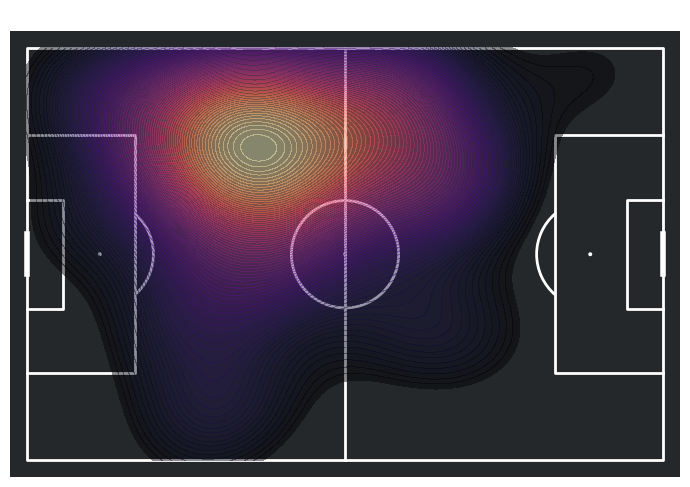

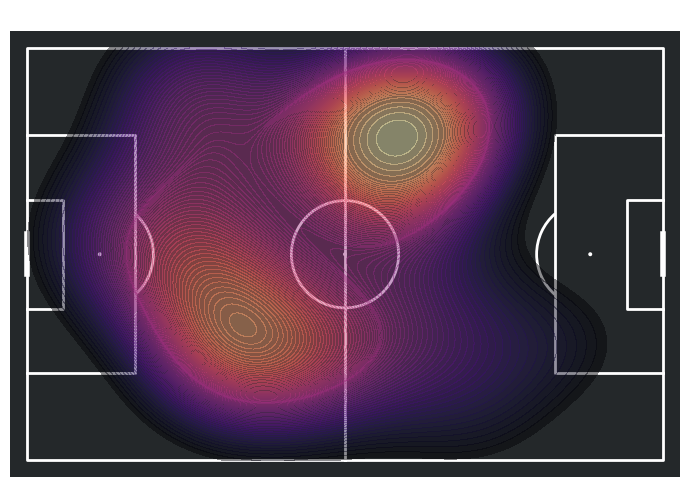

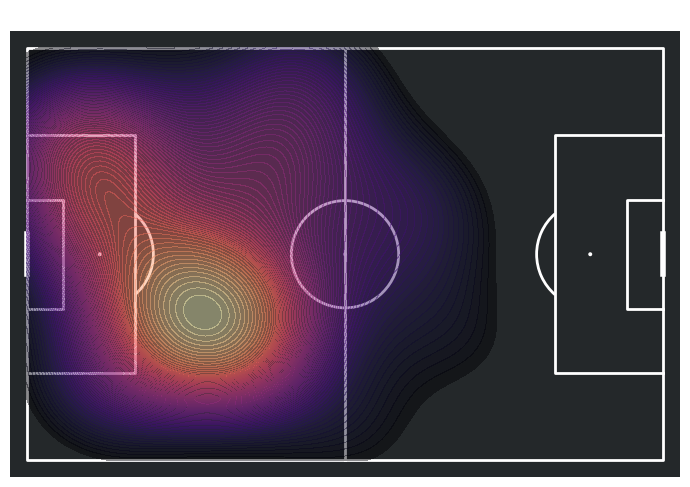

,playerId,player_name,teamId,teamName,recoveries
0,402197,Pedri,65,,34
1,297203,Pablo Fornals,54,,30
2,423282,David Affengruber,833,,29
3,319388,Valentin Rosier,131,,28
4,409467,Antonio Blanco,60,,27
5,448936,Santiago Mouriño,839,,26
6,135098,Johan Mojica,51,,26
7,279320,Luis Milla,819,,25
8,422963,Pathé Ciss,64,,25
9,415345,Hugo Sotelo,62,,24


In [24]:
# 5.a) TODOS los partidos
ranking_all = make_top_recovery_heatmaps_run(
    base_dir=BASE_DIR,
    include_only=None,   # None = procesa todas las carpetas
    top_n=3
)
ranking_all.head(10)